# Amazon Fine foods review - KNN Classifier

### Objectives:

 * Here we will design a simple KNN Classifier model to predict if the given review is Positive or Negative based on the words used in the text.
 

 * We will be using 4 type of Vectorizations of each reviews before building a model, Bag of words, Tf IDF, Average Word2Vec, Tf-IDF weighted Word2Vec.
 

 * We will estimate the model based on Accuracy and F1 Score.
 
 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Connecting with database of cleaned words

conn = sqlite3.connect('G:\ML\Data_Sets\Amazon\Final1_DB.sqlite')

In [3]:
data=pd.read_sql_query( '''select * from reviews''',conn)

## Time based Sorting:

Since the reviews change with respect to time, the accuracy we provide will be similar to the generalised accuracy for future query points if we build our model based on Time based sorting and splitting of data.

In [4]:
sorted_data= data.sort_values('Time',axis=0,ascending = True)

In [7]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel fro...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [8]:
sorted_data.shape

(364171, 12)

## Sample of 100K datapoints

Due to limitation of computational resource, Did the modelling on 1 Lakh sample from a overall 3.7 Lakh data points

In [5]:
sampled_data=sorted_data.head(100000)

In [10]:
print(id(sorted_data))
print(id(sampled_data))

2415592379112
2415592379616


In [11]:
sampled_data['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

# Splitting of Train and Test data(70-30):

In [6]:
train=sampled_data.head(70000)
test=sampled_data.tail(30000)

In [7]:
print(train.shape)
test.shape

(70000, 12)


(30000, 12)

In [14]:
train.tail(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
342751,150122,162846,B005P6TCGW,A124H1A0ZFH0J7,^**^,0,0,positive,1256083200,as advertised,full dose is very sweet(like imitation sweeten...,full dose sweet like imit sweeten prefer water...
183829,185067,200752,B001EPPYSI,A2SDE1AHNU0BYM,"James Henderson ""daddy""",1,1,positive,1256083200,Love these little cocoa tins. Cute Santa twist...,You will love these little tins. Makes great C...,you love littl tin make great christma gift st...
16096,389168,420804,B0002I0GUY,AMM6C75WQA1IS,"Cristina Perez-cordon ""CRISTINAPCORDON""",3,3,positive,1256083200,GREAT PRODUCT!!!,MY DOG HAS VERY SERIOUS STOMACH PROBLEMS AND T...,dog has veri serious stomach problem and this ...


In [15]:
test.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
96759,103370,112257,B000LKUTIM,A1WJTACUJC11Q3,Fred Bauer,1,1,positive,1256083200,Best GF pasta,I like this more than Tinkyada and Mrs. Leeper...,like tinkyada mrs leeper think textur par semo...
154038,232481,252175,B0019SE7P6,AW4IGCYD8DMS6,Fairyflyze,0,0,positive,1256083200,excellent,"Great price! Wonderful creamy, resinous flavor...",great price wonder resin flavor toast skillet ...
97799,311896,337676,B000LKVT0O,A2UE103KUM9WA9,"Sandra M. Van Heest ""SandyVan""",0,0,positive,1256083200,Chai Flavored Mints,"Really unique. If you like Chai tea, you'll lo...",realli uniqu like chai love mint came time per...


## Function for Calculating optimal value of K:

In [7]:
def optimal_k(x,y,fold=10):
    '''
    Finding Optimal K with 10 fold CV.
    
    '''
    cv_score=[]
    nbr=list(range(1,30,2))
    for i in nbr:
        knn=KNeighborsClassifier(i)
        cross_val=cross_val_score(knn,x,y,cv=fold,n_jobs=-1)
        cv_score.append(cross_val.mean())
    e=[1-i for i in cv_score]
    k_optimal=nbr[e.index(min(e))]
    return k_optimal

## Function to plot heat map:

In [8]:
def Heat_CM(a):
    '''
    To plot heat map of confusion matrix
    '''
    tmp=pd.DataFrame(a,index=['positive','negative'],columns=['positive','negative'])
    sns.heatmap(tmp)
    plt.show()
    
    TP=a[0][0]
    FP=a[0][1]
    TN=a[1][1]
    FN=a[1][0]
    
    precision=TP/(TP+FP)
    print('Precision = %s'%(precision))
    Recall =TP/(TP+FN)
    print('Recall = %s'%(Recall))
    F1=(2*((precision*Recall)/(precision+Recall)))
    
    print('F1- Score = %s'%(F1))

# 1.) BOW Vectorization:

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
cv = CountVectorizer()
BOW= cv.fit(train['New'][0:50000])
BOW_train= BOW.transform(train['New'][0:50000])


In [9]:
BOW_train.shape

(50000, 25532)

In [45]:
BOW_test=BOW.transform(test['New'])
BOW_test.shape

(30000, 25532)

In [46]:
#Standardisation

scaler=StandardScaler(with_mean=False)
std_train=scaler.fit_transform(BOW_train)
std_test=scaler.fit_transform(BOW_test)

In [21]:
import scipy
scipy.sparse.issparse(std_train)
scipy.sparse.issparse(std_train[0:25000])

True

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
#Grid sreach CV:
k=range(1,20,1)
param=dict(n_neighbors=k)
knn=KNeighborsClassifier()
grid = GridSearchCV(knn,param,cv=5,scoring='accuracy')


In [ ]:
BOW_grid=grid.fit(std_train[0:30000],train['Score'][:30000])

In [40]:
BOW_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
BOW_grid.best_score_

0.89012

In [42]:
BOW_grid.best_index_

4

In [24]:
k=optimal_k(std_train[0:25000],train['Score'][0:25000],fold=5)
print('The optimal value of K is %d '%(k))


The optimal value of K is 7 


### Brute Force :

In [14]:
final_k= KNeighborsClassifier(n_neighbors= 7,algorithm='brute')
final_k.fit(std_train[0:35000],train['Score'][0:35000])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [15]:
pred=final_k.predict(std_test[0:15000])

In [18]:
BOW_predicted= pred

In [16]:
accuracy= accuracy_score(test['Score'][0:15000],pred)
print(accuracy)

0.8674


### Accuracy of BOW - KNN:

In [17]:
print('The test accuracy of BOW representation of 35k train & 15K test Samples with 5 fold CV is : {} %'.format(accuracy* 100))

The test accuracy of BOW representation of 35k train & 15K test Samples with 5 fold CV is : 86.74 %


### Confusion Matrix:

In [20]:
BOW_CM=confusion_matrix(pred,test['Score'][0:15000],labels=['positive','negative'])

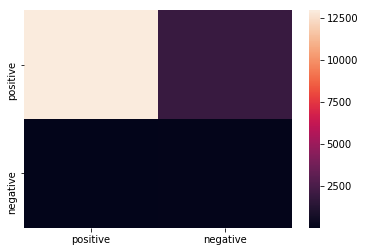

Precision = 0.8677575107296137
Recall = 0.9986879678938025
F1- Score = 0.9286303778391761


In [32]:
Heat_CM(BOW_CM)


### KD Tree:

In [12]:
final_k= KNeighborsClassifier(n_neighbors= 7,algorithm='kd_tree')
start=time.time()
final_k.fit(std_train[0:15000].todense(),train['Score'][0:15000])
print('Completed in time : %d'%(time.time()-start))

Completed in time : 177


In [13]:
import time

In [13]:
start=time.time()
pred=final_k.predict(std_test[0:5000].todense())
print('Completed in time : %d'%(time.time()-start))

Completed in time : 9863


In [15]:
acc_kd=accuracy_score(pred,test['Score'][:5000])
print(acc_kd*100)

86.46000000000001


# 2.) Tf IDF Vectorization:

In [8]:
t=TfidfVectorizer()
tfidf=t.fit(train['New'].values)

In [9]:
train_tfidf=tfidf.transform(train['New'].values)
test_tfidf=tfidf.transform(test['New'].values)
test_tfidf.shape

(30000, 29587)

In [11]:
scaler=StandardScaler(with_mean=False)
std_train1=scaler.fit_transform(train_tfidf)
std_test1=scaler.fit_transform(test_tfidf)

In [39]:
k1=optimal_k(std_train1[0:25000],train['Score'][0:25000],fold=5)
print('The optimal value of K for TfIdf is %d '%(k1))

The optimal value of K for TfIdf is 5 


### Brute Force:

In [40]:
knn_tfidf=KNeighborsClassifier(k1,algorithm='brute')
knn_tfidf.fit(std_train1[0:35000],train['Score'][0:35000])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
pred=knn_tfidf.predict(std_test1[0:15000])

In [43]:
accuracy=accuracy_score(pred,test['Score'][0:15000])

### Accuracy of Tf-IDF KNN:

In [44]:
print('The test accuracy of Tf-IDF representation of 25k Samples with 10 fold CV is : {} %'.format(accuracy * 100))

The test accuracy of Tf-IDF representation of 25k Samples with 10 fold CV is : 86.42666666666666 %


### Confusion Matrix:

In [47]:
tfidf_CM = confusion_matrix(pred,test['Score'][0:15000],labels=['positive','negative'])

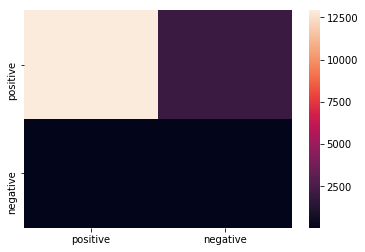

Precision = 0.8659116799571132
Recall = 0.9972987574284171
F1- Score = 0.9269727403156385


In [48]:
Heat_CM(tfidf_CM)

### KD Tree

In [14]:
final_k= KNeighborsClassifier(n_neighbors= 5,algorithm='kd_tree')
start=time.time()
final_k.fit(std_train1[0:15000].todense(),train['Score'][0:15000])
print('Completed in time : %d'%(time.time()-start))

Completed in time : 176


In [15]:
start=time.time()
pred=final_k.predict(std_test1[0:5000].todense())
print('Completed in time : %d seconds'%(time.time()-start))

Completed in time : 10744 seconds


In [16]:
acc_kd=accuracy_score(pred,test['Score'][:5000])
print(acc_kd*100)

86.46000000000001


# WORD2VEC Modelling:

In [17]:
#List of Sentences

sentence_list=[]
for sentence in train['New']:
    sentence_list.append(sentence.split())
sentence_list[1]

['rememb',
 'see',
 'show',
 'air',
 'televis',
 'year',
 'child',
 'sister',
 'later',
 'bought',
 'thirti',
 'someth',
 'use',
 'seri',
 'book',
 'song',
 'student',
 'teach',
 'preschool',
 'turn',
 'whole',
 'school',
 'purchas',
 'along',
 'book',
 'children',
 'the',
 'tradit',
 'live']

In [18]:
from gensim.models import Word2Vec
w2v=Word2Vec(sentence_list, size=50,min_count=1,workers=4)

In [19]:
w2v_list=list(w2v.wv.vocab)

In [20]:
len(w2v_list)

29587

# 3.) Average W2V vectorization:

In [21]:
def avgw2v(x):
    '''
    Calculating Avg W2v of a review
    '''
    sentence_vector=[]
    for sentence in x:
        cnt=0
        s_v=np.zeros(50)
        for words in sentence.split():
            if words in w2v_list:
                v= w2v.wv[words]
                cnt+=1
                s_v+=v        
        if(cnt!=0):
            s_v/=cnt
        sentence_vector.append(s_v)
    return sentence_vector      
        

In [22]:
train_w2v=avgw2v(train['New'])


In [23]:
test_w2v=avgw2v(test['New'])

In [24]:
scaler=StandardScaler(with_mean=False)
std_train2=scaler.fit_transform(train_w2v)
std_test2=scaler.fit_transform(test_w2v)

In [24]:
print(std_train2.shape)
std_test2.shape

(70000, 50)


(30000, 50)

In [20]:
k2= optimal_k(std_train2[0:25000],train['Score'][0:25000],fold=5)
print('The optimal value of K for Avg Word2Vec is %d '%(k2))

The optimal value of K for Avg Word2Vec is 17 


### Brute force:

In [18]:
avgw2v_knn=KNeighborsClassifier(n_neighbors=17, algorithm='brute')
avgw2v_knn.fit(std_train2[0:35000],train['Score'][0:35000])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [21]:
pred=avgw2v_knn.predict(std_test2[0:14000])

In [26]:
avgw2v_pred=pred

In [24]:
accuracy2=accuracy_score(pred,test['Score'][0:14000])
print(accuracy2)

0.8800714285714286


### Accuracy of Avg W2V KNN:

In [31]:
print('The test accuracy of Avg Word2Vec representation of 35k train and 15k test Samples with 5 fold CV is : {} % '.format(accuracy2 * 100))

The test accuracy of Avg Word2Vec representation of 35k train and 15k test Samples with 5 fold CV is : 88.00714285714287 % 


### Confusion Matrix:

In [27]:
avgw2v_CM = confusion_matrix(pred,test['Score'][0:14000],labels=['positive','negative'])

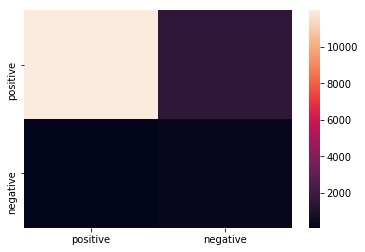

Precision = 0.8831713780918727
Recall = 0.9923897758292662
F1- Score = 0.9346005531102715


In [30]:
Heat_CM(avgw2v_CM)

### KD Tree:

In [32]:
final_k= KNeighborsClassifier(n_neighbors= 17,algorithm='kd_tree')
start=time.time()
print(start)
final_k.fit(std_train2[0:35000],train['Score'][0:35000])
print('Completed in time : %d'%(time.time()-start))

1537709575.4661198
Completed in time : 0


In [33]:
start=time.time()
pred=final_k.predict(std_test2[0:15000])
print('Completed in time : %d seconds'%(time.time()-start))

Completed in time : 292 seconds


In [34]:
acc_kd=accuracy_score(pred,test['Score'][:15000])
print(acc_kd*100)

87.83333333333333


# 4.) Tf-Idf Weighted Word2Vec Vectorization:

In [12]:
#Tf-IDF W2V
def tfidf_w2v(x,y):
    '''
    Computing Tf IDF Word 2 vec for given data points in x
    '''
    feats= t.get_feature_names()
    row=0
    sentence_vector=[]
    for sentence in x:
        s_v=np.zeros(50)
        weights=0
        for words in sentence.split():
            if words in w2v_list:
                try:
                    v=w2v.wv[words]
                    tf_val=y[row,feats.index(words)]
                    s_v+=(v*tf_val)
                    weights+=tf_val
                except:
                    continue            
        if(weights!=0):
            s_v/=weights
        sentence_vector.append(s_v)
        row+=1
    return sentence_vector


In [17]:
train_tfidf_w2v=tfidf_w2v(train['New'],train_tfidf)


In [18]:
test_tfidf_w2v=tfidf_w2v(test['New'],test_tfidf)

In [36]:
import pickle

In [23]:
with open(r'G:\ML\Pickles\tfidf_w2v_train_test.pickle','wb') as f:
    pickle.dump([train_tfidf_w2v,test_tfidf_w2v],f)

In [37]:
with open(r'G:\ML\Pickles\tfidf_w2v_train_test.pickle','rb') as f1:
    pick1,pick2=pickle.load(f1)

In [38]:
scaler=StandardScaler(with_mean=False)
std_train3=scaler.fit_transform(pick1)
std_test3=scaler.fit_transform(pick2)

In [34]:
k3= optimal_k(std_train3[:25000],train['Score'][0:25000],5)
print('The optimal value of K for TfIDF weighted Word2Vec is %d '%(k3))

The optimal value of K for TfIDF weighted Word2Vec is 17 


### Brute force:

In [37]:
knn_tfidf_w2v=KNeighborsClassifier(k3,algorithm='brute')
knn_tfidf_w2v.fit(std_train3[0:35000],train['Score'][:35000])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [38]:
pred=knn_tfidf_w2v.predict(std_test3[0:14000])

In [40]:
acc4=accuracy_score(pred,test['Score'][0:14000])

### Accuracy of Tf- Idf weighted w2v on KNN:

In [42]:
print('The test accuracy of Tf-IDF representation of 35k train & 14k test Samples with 5 fold CV is : {} %'.format(acc4 * 100))

The test accuracy of Tf-IDF representation of 35k train & 14k test Samples with 5 fold CV is : 87.43571428571428 %


### Confusion Matrix:

In [43]:
tfidfw2v_CM = confusion_matrix(pred,test['Score'][0:14000],labels=['positive','negative'])

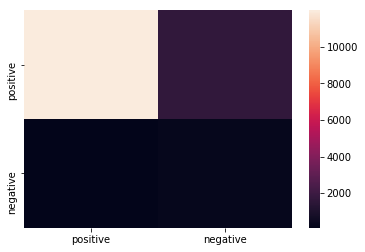

Precision = 0.8788323309373625
Recall = 0.991148978410125
F1- Score = 0.9316176184737395


In [44]:
Heat_CM(tfidfw2v_CM)

### KD tree implementation:

In [39]:
final_k= KNeighborsClassifier(n_neighbors= 17,algorithm='kd_tree')
start=time.time()
final_k.fit(std_train1[0:35000],train['Score'][0:35000])
print('Completed in time : %d'%(time.time()-start))

Completed in time : 0


In [40]:
start=time.time()
pred=final_k.predict(std_test1[0:15000])
print('Completed in time : %d seconds'%(time.time()-start))

Completed in time : 87 seconds


In [42]:
acc_kd=accuracy_score(pred,test['Score'][:15000])
print(acc_kd*100)

86.38


# Comparision of different Text Vectorizations:

In [46]:
from prettytable import PrettyTable

In [56]:
table=PrettyTable()

table.field_names=['Type of vector','No of train pts','No of Test pts','Optimal_k','Accuracy','F1 Score']

table.add_row(['BOW',35000,15000,7,86.64,0.929])
table.add_row(['Tf-Idf',35000,15000,5,86.42,0.927])
table.add_row(['Avg W2V',35000,14000,17,88.00,0.935])
table.add_row(['Tf-Idf W2V',35000,14000,17,87.43,0.932])

print(table)

+----------------+-----------------+----------------+-----------+----------+----------+
| Type of vector | No of train pts | No of Test pts | Optimal_k | Accuracy | F1 Score |
+----------------+-----------------+----------------+-----------+----------+----------+
|      BOW       |      35000      |     15000      |     7     |  86.64   |  0.929   |
|     Tf-Idf     |      35000      |     15000      |     5     |  86.42   |  0.927   |
|    Avg W2V     |      35000      |     14000      |     17    |   88.0   |  0.935   |
|   Tf-Idf W2V   |      35000      |     14000      |     17    |  87.43   |  0.932   |
+----------------+-----------------+----------------+-----------+----------+----------+


# Inference from the above exercise:

*  The accuracy & F1 Score of Avg W2v is slighty greater than others and secondly followed by tfIdf weighted W2V,but the number of test samples used are 1K less than BOW & Tf-IDF


* The K value is very less in Tfidf & BOW and for both the W2V models, the number of neighbors needed, for minimum error is very large.


* KD tree implementation is too much slower than the bruteforce for this data. On an average for 15000 train and 300 test points, it took closely 3 hours whereas bruteforce took 10 mins at the max.


* Tf-IDF with bruteforce implementation is well suited one for internet applications, since time taken to predict xq is less and also K value is lesser(5). So its preferrable for high speed applns with the cost of storing large dimension of data points for each review.


* For High accuracy applications like in medical diagnosis,Avg Word2vec on KNN is used since it has a good F1 Score & Accuracy.
